# HR Analytics: Job Change of Data Scientists
### Created By : Baron Purwa Hartono

## Business Problem Understanding

**Context**  
Sebuah perusahaan yang bergerak di bidang Big Data dan Data Science ingin merekrut Data Scientist di antara orang-orang yang berhasil lulus beberapa kursus yang diadakan oleh perusahaannya. Banyak orang mendaftar untuk pelatihan mereka. Perusahaan ingin mengetahui kandidat mana yang benar-benar ingin bekerja untuk perusahaan setelah pelatihan atau mencari pekerjaan baru karena membantu mengurangi biaya dan waktu serta kualitas pelatihan atau perencanaan kursus dan kategorisasi kandidat. Informasi terkait demografi, pendidikan, pengalaman ada di tangan dari pendaftaran kandidat.

Target :

0 : Tidak mencari perubahan pekerjaan

1 : Mencari perubahan pekerjaan

**Problem Statement :**

Proses perekrutan bisa memakan waktu dan sumber daya jika perusahaan menargetkan semua kandidat tanpa melakukan penyaringan terlebih dahulu. Perusahaan ingin meningkatkan efisiensi rekrutmen dengan mengetahui kandidat mana yang mencari perubahan pekerjaan dalam karir mereka sehingga mereka dapat dipekerjakan sebagai Data Scientist.

Dan jika pelatihannnya diberikan secara gratis kepada semua calon/kandidat, maka biaya tersebut akan menjadi sia-sia jika calon/kandidat yang mengikuti pelatihan tersebut tidak mau direkrut oleh perusahaannya.

**Goals :**

Maka berdasarkan permasalahan tersebut, perusahaan ingin memiliki kemampuan untuk memprediksi kemungkinan seorang kandidat akan/ingin bekerja pada perusahaan tersebut atau tidak, sehingga dapat memfokuskan rekrutmen pada kandidat yang bersedia bekerja pada perusahaan tersebut.

Dan juga, perusahaan ingin mengetahui apa/faktor/variabel apa yang membuat seorang kandidat mau bekerja untuk mereka atau tidak, sehingga mereka dapat membuat rencana yang lebih baik dalam mendekati kandidat potensial (kandidat yang ingin bekerja untuk mereka/perusahaan) .

**Analytic Approach :**

Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan kandidat yang mau bekerja untuk perusahaan dan yang tidak mau.

Kemudian kita akan membangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas seorang kandidat akan/ingin bekerja di perusahaan tersebut atau tidak.

**Metric Evaluation**

<img src='Matrix.png'>

Type 1 error : False Positive  
Konsekuensi: sia-sianya biaya perekrutan, waktu dan sumber daya

Type 2 error : False Negative  
Konsekuensi: kehilangan calon potensial 

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengurangi cost perekrutan dari perusahaan tersebut, tetapi tanpa membuat menjadi kurangnya/tidak cukup kandidat potensial yang dibutuhkan perusahaan. Jadi harus kita seimbangkan nanti antara precision dan recallnya dari kelas positive (kandidat potensial). Jadi nanti metric utama yang akan kita gunakan adalah roc_auc.

## Data Understanding

Dataset source : https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists

Note : 
- Dataset tidak seimbang
- Sebagian besar fitur bersifat kategori (Nominal, Ordinal, Binary), beberapa dengan kardinalitas tinggi
- Setiap baris data merepresentasikan informasi seorang kandidat yang ditawarkan bekerja dimasa lalu

### Attribute Information

| Attribute | Data Type, Length | Description |
| --- | --- | --- |
| enrollee_id | Long | Unique ID for candidate |
| city | Text | City code |
| city_development_index | Float | Developement index of the city (scaled) |
| gender | Text | Gender of candidate |
| relevent_experience | Text | Relevant experience of candidate |
| enrolled_university | Text | Type of University course enrolled if any |
| education_level | Text | Education level of candidate |
| major_discipline | Text | Education major discipline of candidate |
| experience | Text | Candidate total experience in years |
| company_size | Text | No of employees in current employer's company |
| company_type | Text | Type of current employer |
| last_new_job | Text | Difference in years between previous job and current job |
| training_hours | Long | training hours completed |
| target | Float | 0 – Not looking for job change, 1 – Looking for a job change |

In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [2]:
#Load Dataset
df = pd.read_csv("aug_train.csv")
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [3]:
# Count and Datatype for each Column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

## Data Cleaning

Ada data yang hilang/kosong dibeberapa fitur/kolom, kemudian fitur/kolom enrolle_id tidak berguna untuk analisis dan modeling, maka kita akan memperbaiki semua datanya dan membuatnya menjadi siap pakai untuk melakukan analisa terhadap masalahnya dan juga pembuatan model machine learningnya.

In [4]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,enrollee_id,int64,0,0.00,19158,"[3388, 3365]"
1,city,object,0,0.00,123,"[city_43, city_106]"
2,city_development_index,float64,0,0.00,93,"[0.5579999999999999, 0.556]"
3,gender,object,4508,23.53,3,"[Female, nan]"
4,relevent_experience,object,0,0.00,2,"[Has relevent experience, No relevent experience]"
5,enrolled_university,object,386,2.01,3,"[Full time course, Part time course]"
6,education_level,object,460,2.40,5,"[High School, Primary School]"
7,major_discipline,object,2813,14.68,6,"[STEM, Other]"
8,experience,object,65,0.34,22,"[3, >20]"
9,company_size,object,5938,30.99,8,"[500-999, 50-99]"


Pertama kita akan menghapus kolom enrollee_id, karena ini hanyalah id unik yg membedakan setiap kandidat dan tidak berguna untuk analisa yang akan kita lakukan dan juga tidak berguna dalam pembuatan model machine learning nantinya.

Sebagai info tambahan, kita dapat mengetahui bahwa tidak ada data yang duplikat dari dataset kita dengan melihat jumlah data unik dari kolom enrollee_id, dimana jumlah unik datanya sama dengan jumlah keseluruhan data kita, oleh karena itu dataset kita kali ini tidak memiliki data yang duplikat.

In [5]:
df.drop(['enrollee_id'],axis=1, inplace=True)

Mari kita check informasi dataframenya lagi

In [6]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,city,object,0,0.00,123,"[city_89, city_41]"
1,city_development_index,float64,0,0.00,93,"[0.921, 0.8240000000000001]"
2,gender,object,4508,23.53,3,"[Male, Female]"
3,relevent_experience,object,0,0.00,2,"[Has relevent experience, No relevent experience]"
4,enrolled_university,object,386,2.01,3,"[Full time course, Part time course]"
5,education_level,object,460,2.40,5,"[Graduate, Masters]"
6,major_discipline,object,2813,14.68,6,"[Business Degree, Humanities]"
7,experience,object,65,0.34,22,"[8, nan]"
8,company_size,object,5938,30.99,8,"[1000-4999, 10/49]"
9,company_type,object,6140,32.05,6,"[Funded Startup, Other]"


Ok sekarang kolom enrollee_id sudah tidak ada. 

Berikutnya, kalau kita perhatikan, kolom experience ini cukup menarik tipe datanya, dimana semestinya berdasarkan penjelasan kolom experience, tipe datanya bukan object/string melainkan integer atau float, karena kolom experience adalah lama waktu pengalaman kerjanya dalam satuan tahun. Mari sekarang kita check lebih lanjut data kolom experience.

In [7]:
df['experience'].unique()

array(['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4',
       '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan],
      dtype=object)

Terlihat bahwa ternyata alasan dari kolom experience memiliki tipe data object/string adalah karena ada data >20 dan juga <1 dimana kedua data ini tidak bisa disimpan dengan tipe data integer maupun float.

Berikutnya, sekarang mari kita visualisasikan missing values/data yang hilang pada dataframe kita dengan menggunakan library missingno

reference : 

https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009

https://github.com/ResidentMario/missingno

#### Bar Plot

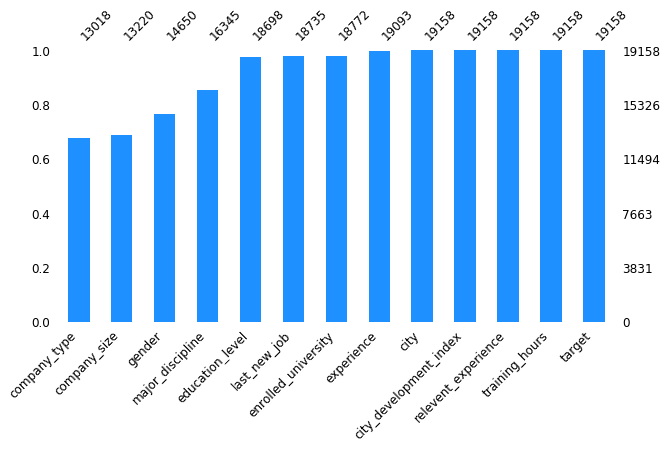

In [8]:
missingno.bar(df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

Terlihat dari Bar Plot tersebut, bahwa kolom company_type, company_size, gender, major_discipline, education_level, last_new_job, enrolled_university, dan experience memiliki missing values/data yang hilang. (informasi ini sebenarnya dapat dilihat juga ditable atas)

Kemudian berdasarkan Bar Plot tersebut juga, kolom company_type adalah kolom yang memiliki data yang hilang terbanyak, sedangkan kolom experience memiliki hanya sedikit saja data yang hilang.

#### Matrix Plot

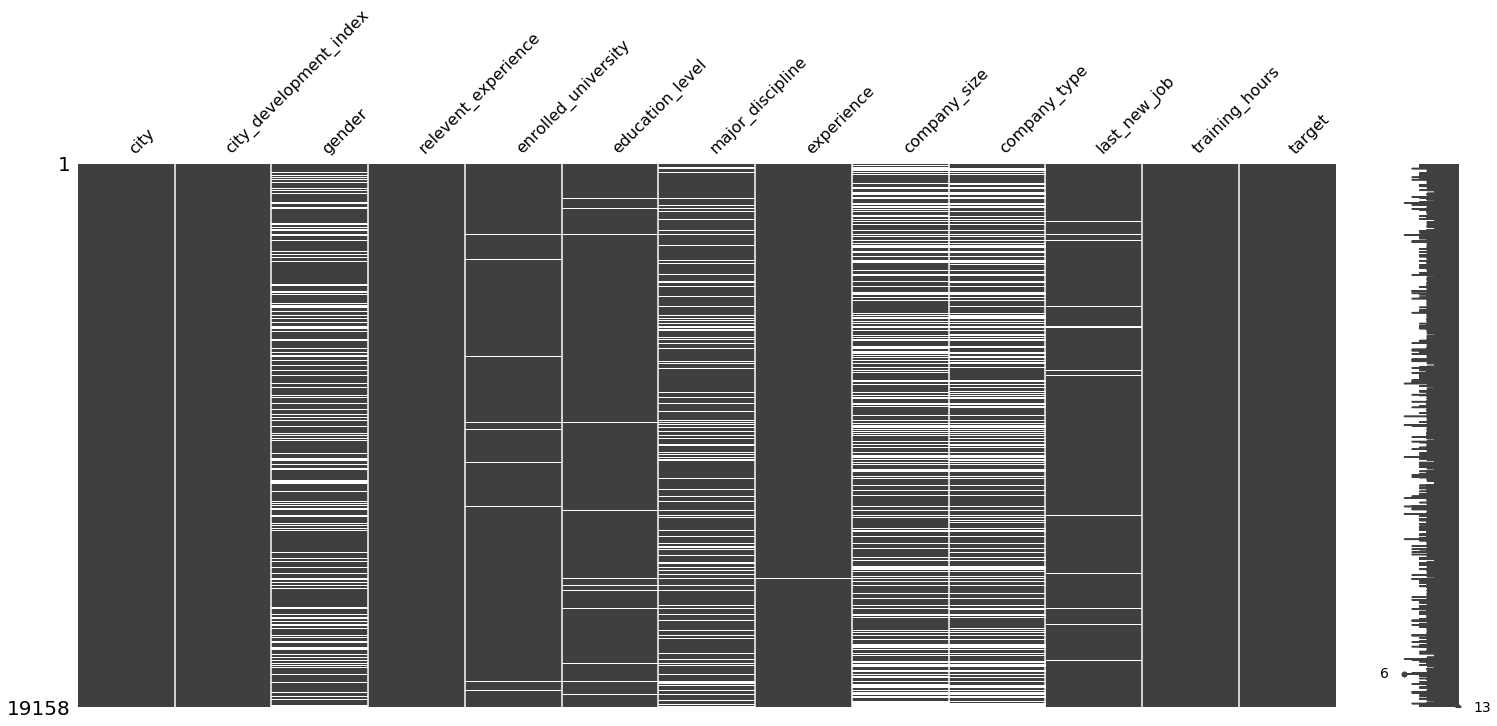

In [9]:
missingno.matrix(df)

Terlihat bahwa missing value/data yang hilang pada setiap kolom memiliki pola yang cukup acak.

#### Heatmap

Di bawah ini kita memplot Heatmap yang menunjukkan korelasi nulitas antara berbagai kolom yang memiliki data yang hilang pada dataset kita.

Korelasi nulitas berkisar dari -1 hingga 1.

- -1 - Korelasi Negatif yang menyatakan bahwa jika nilai satu variabel ada maka nilai variabel lain pasti tidak ada.
- 0 - Tidak ada korelasi yang menyatakan bahwa nilai variabel yang ada atau tidak ada tidak berpengaruh satu sama lain.
- 1 - Korelasi Positif yang menyatakan bahwa jika nilai satu variabel ada maka nilai yang lain pasti ada

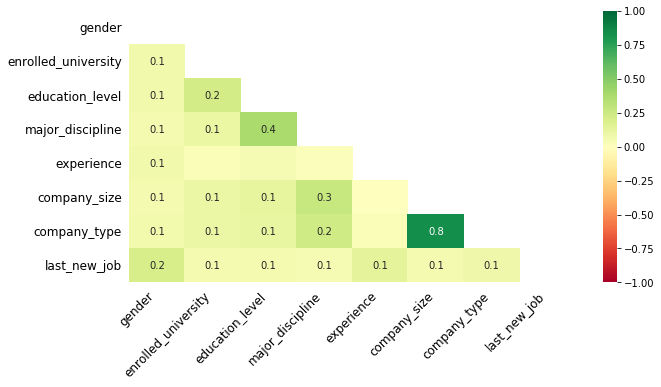

In [10]:
missingno.heatmap(df, cmap="RdYlGn", figsize=(10,5), fontsize=12);

Terlihat dari Heatmap tersebut, bahwa rata-rata missing values/data yang hilang antara 1 kolom dengan kolom yang lainnya itu tidak berhubungan/berkorelasi, tetapi untuk kolom company_type dengan kolom company_size memiliki hubungan/korelasi yang cukup kuat dengan nilai 0.8 yang berartikan bahwa bila kolom company_type itu ada datanya, biasanya kolom company_size juga ada datanya dan begitu pula sebaliknya.

#### Dendogram

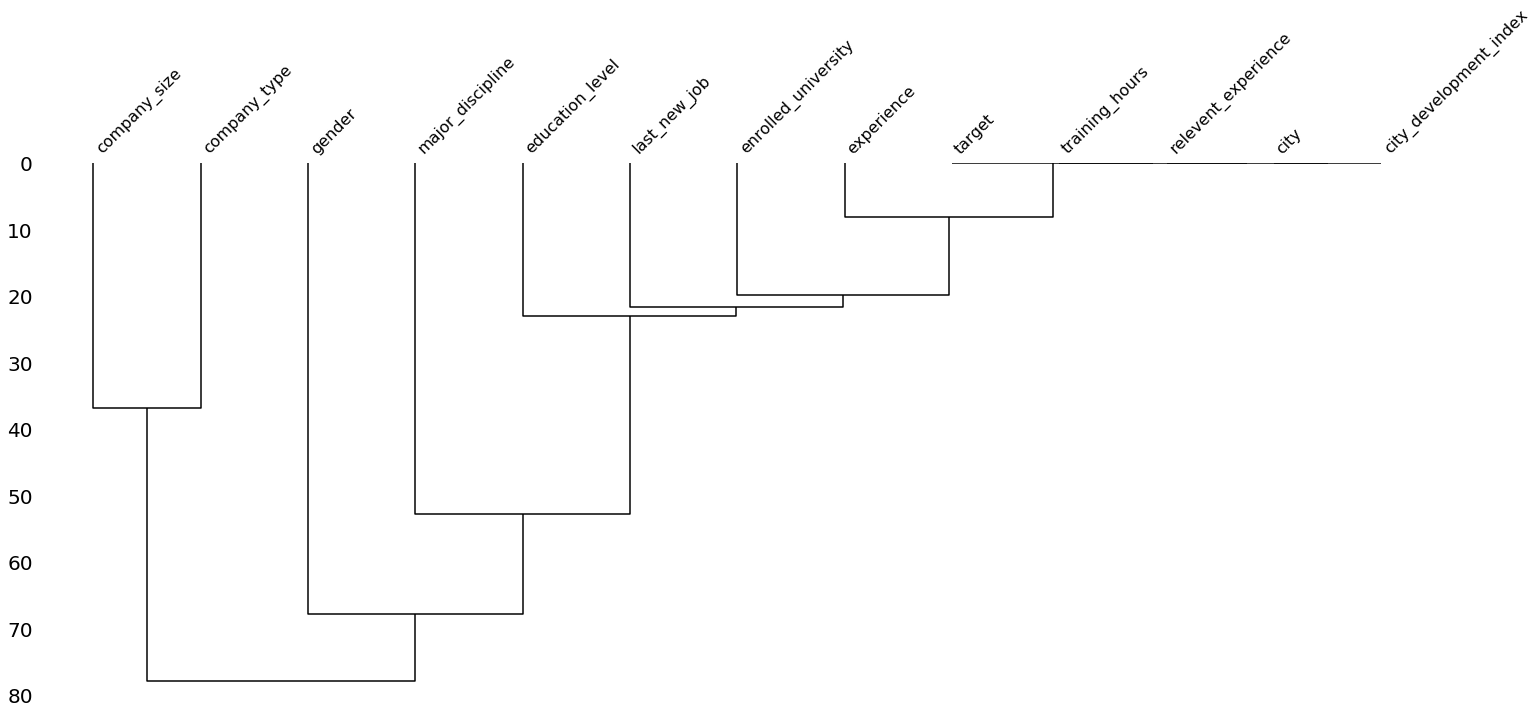

In [11]:
missingno.dendrogram(df)
plt.show()

Berdasarkan dendogram tersebut, terlihat bahwa benar kolom company_size dan company_type memang cukup berkorelasi dari segi missing values/datanya. Kemudian kolom target, training_hours, relevent_experience, city, dan city_development_index berada di titik 0 karena mereka tidak mempunyai missing values/data.

Sekarang mari kita coba check & analisa hubungan antara company_size dengan company_type

In [12]:
df.groupby(['company_type','company_size']).count()[['target']].transpose()

company_type Early Stage Startup                            Funded Startup  \
company_size               10/49 100-500 50-99 500-999  <10          10/49   
target                       176      27   109       2  286            193   

company_type                              NGO                                 \
company_size 100-500 50-99 500-999  <10 10/49 100-500 1000-4999 10000+ 50-99   
target           214   390      54  144    32     174        73     37    77   

company_type                       Other                                 \
company_size 500-999 5000-9999 <10 10/49 100-500 1000-4999 10000+ 50-99   
target            37        29  36    12      20        15     16    18   

company_type                       Public Sector                           \
company_size 500-999 5000-9999 <10         10/49 100-500 1000-4999 10000+   
target            11         7  14            43     151       165    150   

company_type                             Pvt Ltd                           \
company_size 50-99 500-999 5000-9999 <10   10/49 100-500 1000-4999 10000+   
target         116      87        79  35     910    1833      1016   1739   

company_type                               
company_size 50-99 500-999 5000-9999  <10  
target        2151     622       412  728

Terlihat dari info table diatas, bahwa ada perbedaan company_size pada company_type yang berbeda. Sebagai contoh, company_type Early Stage Startup dan juga Funded Startup, company_size perusahaannya belum ada yang sampai diatas 1000 orang.

Mari kita rubah 10/49 menjadi 10-49 terlebih dahulu, karena semestinya range seperti itu dan menggunakan tanda - bukan / .

In [13]:
df['company_size'] = df['company_size'].replace('10/49','10-49')

Mari sekarang kita lihat lebih detail pola untuk setiap company_type.

##### Early Stage Startup

In [14]:
df.groupby(['company_type','company_size']).count()[['target']].loc['Early Stage Startup']

,target
company_size,
10-49,176
100-500,27
50-99,109
500-999,2
<10,286


In [15]:
df.groupby(['company_type','company_size']).count()[['target']].loc['Early Stage Startup']/df.groupby(['company_type','company_size']).count()[['target']].loc['Early Stage Startup'].sum() * 100

,target
company_size,
10-49,29.333333
100-500,4.500000
50-99,18.166667
500-999,0.333333
<10,47.666667


Terlihat bahwa kalau company_type Early Stage Startup, company_sizenya paling sering itu <10 orang

##### Funded Startup

In [16]:
df.groupby(['company_type','company_size']).count()[['target']].loc['Funded Startup']

,target
company_size,
10-49,193
100-500,214
50-99,390
500-999,54
<10,144


In [17]:
df.groupby(['company_type','company_size']).count()[['target']].loc['Funded Startup']/df.groupby(['company_type','company_size']).count()[['target']].loc['Funded Startup'].sum() * 100

,target
company_size,
10-49,19.396985
100-500,21.507538
50-99,39.195980
500-999,5.427136
<10,14.472362


Terlihat bahwa kalau company_type Funded Startup, company_sizenya paling sering itu 50-99 orang

##### NGO

In [18]:
df.groupby(['company_type','company_size']).count()[['target']].loc['NGO']

,target
company_size,
10-49,32
100-500,174
1000-4999,73
10000+,37
50-99,77
500-999,37
5000-9999,29
<10,36


In [19]:
df.groupby(['company_type','company_size']).count()[['target']].loc['NGO']/df.groupby(['company_type','company_size']).count()[['target']].loc['NGO'].sum() * 100

,target
company_size,
10-49,6.464646
100-500,35.151515
1000-4999,14.747475
10000+,7.474747
50-99,15.555556
500-999,7.474747
5000-9999,5.858586
<10,7.272727


Terlihat bahwa kalau company_type NGO, company_sizenya paling sering itu 100-500 orang, dan type ini juga cukup sangat beragam company_sizenya.

##### Public Sector

In [20]:
df.groupby(['company_type','company_size']).count()[['target']].loc['Public Sector']

,target
company_size,
10-49,43
100-500,151
1000-4999,165
10000+,150
50-99,116
500-999,87
5000-9999,79
<10,35


In [21]:
df.groupby(['company_type','company_size']).count()[['target']].loc['Public Sector']/df.groupby(['company_type','company_size']).count()[['target']].loc['Public Sector'].sum() * 100

,target
company_size,
10-49,5.205811
100-500,18.280872
1000-4999,19.975787
10000+,18.159806
50-99,14.043584
500-999,10.532688
5000-9999,9.564165
<10,4.237288


Terlihat bahwa kalau company_type Public Sector, company_sizenya paling sering itu 1000-4999 orang, walau tidak terlalu jauh dengan yang lain, dan type ini cukup sangat beragam company_sizenya.

##### Pvt Ltd

In [22]:
df.groupby(['company_type','company_size']).count()[['target']].loc['Pvt Ltd']

,target
company_size,
10-49,910
100-500,1833
1000-4999,1016
10000+,1739
50-99,2151
500-999,622
5000-9999,412
<10,728


In [23]:
df.groupby(['company_type','company_size']).count()[['target']].loc['Pvt Ltd']/df.groupby(['company_type','company_size']).count()[['target']].loc['Pvt Ltd'].sum() * 100

,target
company_size,
10-49,9.669536
100-500,19.477208
1000-4999,10.795877
10000+,18.478376
50-99,22.856232
500-999,6.609287
5000-9999,4.377856
<10,7.735629


Terlihat bahwa kalau company_type Pvt Ltd, company_sizenya paling sering itu 50-99 orang, walau tidak terlalu jauh dengan yang lain, dan type ini juga cukup sangat beragam company_sizenya.

##### Other

In [24]:
df.groupby(['company_type','company_size']).count()[['target']].loc['Other']

,target
company_size,
10-49,12
100-500,20
1000-4999,15
10000+,16
50-99,18
500-999,11
5000-9999,7
<10,14


In [25]:
df.groupby(['company_type','company_size']).count()[['target']].loc['Other']/df.groupby(['company_type','company_size']).count()[['target']].loc['Other'].sum() * 100

,target
company_size,
10-49,10.619469
100-500,17.699115
1000-4999,13.274336
10000+,14.159292
50-99,15.929204
500-999,9.734513
5000-9999,6.194690
<10,12.389381


Terlihat bahwa kalau company_type Other, company_sizenya paling sering itu 100-500 orang, walau tidak terlalu jauh dengan yang lain, dan type ini juga cukup sangat beragam company_sizenya.

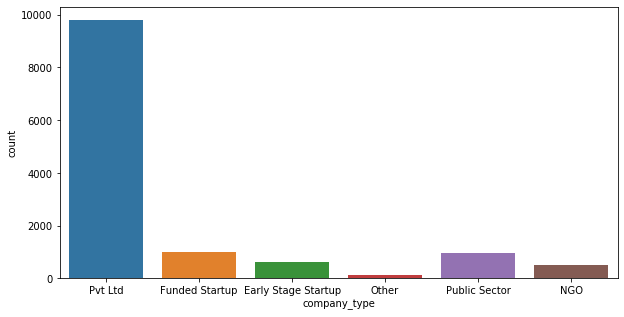

In [26]:
plt.figure(figsize = (10,5))
sns.countplot(df['company_type'])
plt.show()

Kemudian terlihat juga bahwa paling banyak kandidat yang mendaftar itu berasal dari company yang company_typenya Pvt Ltd, dan perbandingannya dengan company_type yang lain cukup jauh.

Dari hasil analisa company_type dan company_size, dapat disimpulkan bahwa meskipun terlihat pola yang agak berbeda untuk beberapa company_type terhadap company_sizenya, tetapi karena masih ada bercampur (masih ada yg sama) company_sizenya untuk beberapa company_type yang berbeda, maka kita tidak dapat mengisi company_type hanya berdasarkan company_size dan begitu juga sebaliknya (dimana hasilnya jadi bisa kurang akurat). 

Dan juga data yang missing ini untuk ke 2 kolomnya juga cukup banyak yaitu sekitar 30%. Dimana ini kemungkinan besar dikarenakan kandidat tersebut sedang tidak bekerja pada suatu perusahaan.

Oleh karena itu, mari kita check dan analisa lebih lanjut apakah mungkin kita dapat mengisi missing value di company_size dan juga company_type dengan informasi bahwa dia sedang tidak bekerja atau data tersebut hilang/tidak ada. Dimana ini hanya berlaku untuk baris data yang baik company_size dan company_typenya tidak ada/hilang (22nya missing tidak hanya salah 1). Dan untuk baris data yang missingnya hanya salah 1 saja dari kolom tersebut, akan kita hapus saja baris datanya nanti supaya data yang dihasilkan lebih akurat.

In [27]:
df[df['company_type'].isna() & df['company_size'].isna()]['target'].value_counts()

0.0    3118
1.0    2242
Name: target, dtype: int64

In [28]:
df[(df['company_type'].isna() == False) | (df['company_size'].isna() == False)]['target'].value_counts()

0.0    11263
1.0     2535
Name: target, dtype: int64

In [29]:
df[df['company_type'].isna() & df['company_size'].isna()]['target'].mean()

0.41828358208955224

In [30]:
df[(df['company_type'].isna() == False) | (df['company_size'].isna() == False)]['target'].mean()

0.18372227859110016

Terlihat bahwa asumsi tadi terbukti kemungkinan benar, dimana baris data yang company_type dan company_sizenya kosong kecenderungan untuk mau terima tawaran kerjanya lebih besar dari baris data yang ada isinya. 

Ini masuk akal, karena bila seorang kandidat sedang tidak bekerja diperusahaan lain, maka kemungkinan dia untuk menerima tawaran kerjanya akan lebih tinggi.

Ok berarti untuk kali ini, mari kita isi data yang kosong dari kolom company_type dan company_size dengan Not Available.

In [31]:
nan_index=(df[(df['company_type'].isna()) & (df['company_size'].isna())]).index
df['company_type'][nan_index]='Not Available'
df['company_size'][nan_index]='Not Available'

print('Banyak baris data yang diisi : ', len(nan_index))

Banyak baris data yang diisi :  5360


In [32]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,city,object,0,0.00,123,"[city_109, city_74]"
1,city_development_index,float64,0,0.00,93,"[0.743, 0.925]"
2,gender,object,4508,23.53,3,"[nan, Other]"
3,relevent_experience,object,0,0.00,2,"[Has relevent experience, No relevent experience]"
4,enrolled_university,object,386,2.01,3,"[no_enrollment, Part time course]"
5,education_level,object,460,2.40,5,"[High School, Primary School]"
6,major_discipline,object,2813,14.68,6,"[Business Degree, Other]"
7,experience,object,65,0.34,22,"[7, 17]"
8,company_size,object,578,3.02,9,"[500-999, 1000-4999]"
9,company_type,object,780,4.07,7,"[Funded Startup, Other]"


Ok terlihat sekarang kolom company_size dan juga company_type sudah memiliki jauh lebih sedikit data yang kosongnya (nan).

Mari kita lanjutkan proses pembersihan dataset kita.

#### Remove Unused Data

Sekarang, mari kita hapus kolom gender dari dataset kita, dimana alasan kolom gender dihapus adalah untuk supaya analisa yang kita lakukan dan juga model ML yang nanti kita akan buat, tidak melakukan diskriminasi terhadap gender. 

Dimana semestinya, gender tidak mempengaruhi/membedakan kandidat mana yang tertarik ingin bekerja untuk perusahaannya dan yang tidak. (ini hanya asumsi saya saja berdasarkan pengalaman dan pengetahuan saya, boleh saja anda buktikan kembali sendiri)

In [33]:
df.drop(['gender'],axis=1, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   relevent_experience     19158 non-null  object 
 3   enrolled_university     18772 non-null  object 
 4   education_level         18698 non-null  object 
 5   major_discipline        16345 non-null  object 
 6   experience              19093 non-null  object 
 7   company_size            18580 non-null  object 
 8   company_type            18378 non-null  object 
 9   last_new_job            18735 non-null  object 
 10  training_hours          19158 non-null  int64  
 11  target                  19158 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 1.8+ MB


Setelah kita menghapus kolom gender, kita akan menghapus semua baris data yang memiliki missing values/data, tetapi sebelum itu, mari kita lihat dulu distribusi data dari setiap fiturnya, dimana akan kita bandingkan juga dengan distribusi dari data kita yang  sudah dihapus baris data yang memiliki data yg kosong/hilang. Dimana tujuannya supaya memastikan data yg kita miliki setelah dihapus baris2 yg memiliki missing data, masih memiliki distribusi yang kurang lebih sama seperti sebelumnya.

##### Numerical Features Distribution

In [35]:
df.describe()

,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000
mean,0.828848,65.366896,0.249348
std,0.123362,60.058462,0.432647
min,0.448000,1.000000,0.000000
25%,0.740000,23.000000,0.000000
50%,0.903000,47.000000,0.000000
75%,0.920000,88.000000,0.000000
max,0.949000,336.000000,1.000000


In [36]:
df.dropna().describe()

,city_development_index,training_hours,target
count,14791.000000,14791.000000,14791.000000
mean,0.831327,65.283956,0.254750
std,0.122892,60.060585,0.435735
min,0.448000,1.000000,0.000000
25%,0.743000,23.000000,0.000000
50%,0.910000,47.000000,0.000000
75%,0.920000,88.000000,1.000000
max,0.949000,336.000000,1.000000


Seperti yang kita lihat distribusi data dari kolom/fitur numerik yang kita punya cukup hampir sama setelah data yang kosong/hilang dihapus, dimana dapat dilihat dari mean dan stdnya.

Mari kita check perubahan distribusi data dari kolom target kita dengan lebih detail.

In [37]:
df['target'].value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

In [38]:
df.dropna()['target'].value_counts()

0.0    11023
1.0     3768
Name: target, dtype: int64

In [39]:
df['target'].value_counts()/len(df['target']) * 100

0.0    75.065247
1.0    24.934753
Name: target, dtype: float64

In [40]:
df.dropna()['target'].value_counts()/len(df.dropna()['target']) * 100

0.0    74.525049
1.0    25.474951
Name: target, dtype: float64

Terlihat bahwa distribusi kolom target kita kurang lebih sama seperti sebelum data yang kosong dihapus.

Mari sekarang kita check juga distribusi data kolom categorical kita

##### Categorical Features Distribution

In [41]:
df.describe(include=['O'])

,city,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,19158,18772,18698,16345,19093,18580,18378,18735
unique,123,2,3,5,6,22,9,7,6
top,city_103,Has relevent experience,no_enrollment,Graduate,STEM,>20,Not Available,Pvt Ltd,1
freq,4355,13792,13817,11598,14492,3286,5360,9817,8040


In [42]:
df.dropna().describe(include=['O'])

,city,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,14791,14791,14791,14791,14791,14791,14791,14791,14791
unique,122,2,3,3,6,22,9,7,6
top,city_103,Has relevent experience,no_enrollment,Graduate,STEM,>20,Not Available,Pvt Ltd,1
freq,3669,11663,11495,10475,13086,2956,3612,8481,6478


Terlihat bahwa untuk kolom categorical, ada 1 data kota/city yang menghilang, dan 2 data education_level yang menghilang. Mari kita check lebih lanjut ke 2 kolom tersebut.

In [43]:
df['city'].unique()

array(['city_103', 'city_40', 'city_21', 'city_115', 'city_162',
       'city_176', 'city_160', 'city_46', 'city_61', 'city_114',
       'city_13', 'city_159', 'city_102', 'city_67', 'city_100',
       'city_16', 'city_71', 'city_104', 'city_64', 'city_101', 'city_83',
       'city_105', 'city_73', 'city_75', 'city_41', 'city_11', 'city_93',
       'city_90', 'city_36', 'city_20', 'city_57', 'city_152', 'city_19',
       'city_65', 'city_74', 'city_173', 'city_136', 'city_98', 'city_97',
       'city_50', 'city_138', 'city_82', 'city_157', 'city_89',
       'city_150', 'city_70', 'city_175', 'city_94', 'city_28', 'city_59',
       'city_165', 'city_145', 'city_142', 'city_26', 'city_12',
       'city_37', 'city_43', 'city_116', 'city_23', 'city_99', 'city_149',
       'city_10', 'city_45', 'city_80', 'city_128', 'city_158',
       'city_123', 'city_7', 'city_72', 'city_106', 'city_143', 'city_78',
       'city_109', 'city_24', 'city_134', 'city_48', 'city_144',
       'city_91', 'city_

In [44]:
df.dropna()['city'].unique()

array(['city_103', 'city_40', 'city_21', 'city_162', 'city_176',
       'city_46', 'city_61', 'city_114', 'city_13', 'city_159',
       'city_102', 'city_160', 'city_16', 'city_64', 'city_101',
       'city_83', 'city_105', 'city_104', 'city_73', 'city_67', 'city_75',
       'city_100', 'city_93', 'city_11', 'city_36', 'city_20', 'city_71',
       'city_57', 'city_19', 'city_65', 'city_74', 'city_173', 'city_136',
       'city_98', 'city_97', 'city_90', 'city_50', 'city_138', 'city_82',
       'city_89', 'city_150', 'city_175', 'city_28', 'city_115',
       'city_94', 'city_59', 'city_165', 'city_145', 'city_142',
       'city_12', 'city_37', 'city_43', 'city_116', 'city_157', 'city_99',
       'city_23', 'city_10', 'city_45', 'city_41', 'city_128', 'city_70',
       'city_123', 'city_7', 'city_72', 'city_106', 'city_143', 'city_78',
       'city_109', 'city_24', 'city_158', 'city_48', 'city_144',
       'city_91', 'city_146', 'city_133', 'city_134', 'city_167',
       'city_27', 'city

In [45]:
df['city'].unique()[np.isin(df['city'].unique(), df.dropna()['city'].unique(), invert=True)]

array(['city_140'], dtype=object)

Terlihat untuk data kota, data yang jadi hilang adalah data dari city_140.

In [46]:
df['education_level'].unique()

array(['Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School'],
      dtype=object)

In [47]:
df.dropna()['education_level'].unique()

array(['Graduate', 'Masters', 'Phd'], dtype=object)

In [48]:
df['education_level'].unique()[np.isin(df['education_level'].unique(), df.dropna()['education_level'].unique(), invert=True)]

array(['High School', nan, 'Primary School'], dtype=object)

Terlihat untuk data education_level, data yang hilang adalah data lulusan High School, dan juga Primary School, untuk data yang nan masih masuk akal untuk dihapus, karena semestinya biasanya orang minimal itu education_levelnya Primary School, dan kalau nan berarti kemungkinan karena datanya yang memang kosong/hilang bukan karena dia tidak pernah sekolah. (tapi ini kembali lagi masih asumsi saja)

Mari sekarang terlebih dahulu kita check data High School dan data Primary School itu biasa kosong datanya di kolom apa saja.

In [49]:
dfHasilFilter = df[(df['education_level'] == 'High School') | (df['education_level'] == 'Primary School')]
dfHasilFilter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 6 to 19157
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    2325 non-null   object 
 1   city_development_index  2325 non-null   float64
 2   relevent_experience     2325 non-null   object 
 3   enrolled_university     2269 non-null   object 
 4   education_level         2325 non-null   object 
 5   major_discipline        0 non-null      object 
 6   experience              2320 non-null   object 
 7   company_size            2182 non-null   object 
 8   company_type            2252 non-null   object 
 9   last_new_job            2252 non-null   object 
 10  training_hours          2325 non-null   int64  
 11  target                  2325 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 236.1+ KB


In [50]:
listItem = []
for col in dfHasilFilter.columns :
    listItem.append([col, dfHasilFilter[col].dtype, dfHasilFilter[col].isna().sum(), round((dfHasilFilter[col].isna().sum()/len(dfHasilFilter[col])) * 100,2),
                    dfHasilFilter[col].nunique(), list(dfHasilFilter[col].drop_duplicates().sample().values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,city,object,0,0.00,104,[city_101]
1,city_development_index,float64,0,0.00,77,[0.493]
2,relevent_experience,object,0,0.00,2,[No relevent experience]
3,enrolled_university,object,56,2.41,3,[Part time course]
4,education_level,object,0,0.00,2,[High School]
5,major_discipline,object,2325,100.00,0,[nan]
6,experience,object,5,0.22,22,[18]
7,company_size,object,143,6.15,9,[5000-9999]
8,company_type,object,73,3.14,7,[NGO]
9,last_new_job,object,73,3.14,6,[>4]


Terlihat bahwa kalau education_level High School dan Primary School, major_disciplinenya itu kosong semua, dimana ini masuk akal karena mereka belum kuliah.

Kemudian kalau enrolled_university terlihat bahwa yang missing datanya hanya sekitar 56 baris data saja, mari kita check terlebih lanjut 3 unique values dari enrolled_university dari kandidat yang education_levelnya High School dan Primary School

In [51]:
df[(df['education_level'] == 'High School') | (df['education_level'] == 'Primary School')]['enrolled_university'].value_counts()

no_enrollment       1195
Full time course     897
Part time course     177
Name: enrolled_university, dtype: int64

In [52]:
df[(df['education_level'] == 'High School')]['enrolled_university'].value_counts()

no_enrollment       940
Full time course    864
Part time course    166
Name: enrolled_university, dtype: int64

In [53]:
df[(df['education_level'] == 'Primary School')]['enrolled_university'].value_counts()

no_enrollment       255
Full time course     33
Part time course     11
Name: enrolled_university, dtype: int64

Terlihat bahwa ternyata paling banyak itu no_enrollment yang artinya adalah bahwa benar kandidat tersebut tidak kuliah, tetapi kalau kita lihat juga bahwa ada juga yang Full time course dan juga Part time course, ini kemungkinan kandidat tersebut sedang dalam proses kuliah dan belum lulus, dimana menyebabkan education_levelnya masih yang sebelum saat dia kuliah. Tetapi bisa juga ini dikarenakan salah input data. 

Karena kita tidak mengenal pembuat datanya dan tidak dapat menanyakannya langsung, mari kita gunakan saja asumsi yang pertama, bahwa data ini benar adanya, dan kandidat tersebut berarti memang sedang dalam proses kuliah dan belum lulus. Jadi data ini tidak akan kita rubah, melainkan kita akan mengisi missing valuesnya dengan no_enrollment saja (modus data kolomnya)

In [54]:
nan_index=(df[(df['enrolled_university'].isna()) & ((df['education_level']=='High School') | (df['education_level']=='Primary School'))]).index
df['enrolled_university'][nan_index]='no_enrollment'

print('Banyak baris data yang diisi : ', len(nan_index))

Banyak baris data yang diisi :  56


In [55]:
dfHasilFilter = df[(df['education_level'] == 'High School') | (df['education_level'] == 'Primary School')]
listItem = []
for col in dfHasilFilter.columns :
    listItem.append([col, dfHasilFilter[col].dtype, dfHasilFilter[col].isna().sum(), round((dfHasilFilter[col].isna().sum()/len(dfHasilFilter[col])) * 100,2),
                    dfHasilFilter[col].nunique(), list(dfHasilFilter[col].drop_duplicates().sample().values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,city,object,0,0.00,104,[city_27]
1,city_development_index,float64,0,0.00,77,[0.913]
2,relevent_experience,object,0,0.00,2,[No relevent experience]
3,enrolled_university,object,0,0.00,3,[no_enrollment]
4,education_level,object,0,0.00,2,[High School]
5,major_discipline,object,2325,100.00,0,[nan]
6,experience,object,5,0.22,22,[8]
7,company_size,object,143,6.15,9,[Not Available]
8,company_type,object,73,3.14,7,[Early Stage Startup]
9,last_new_job,object,73,3.14,6,[4]


In [56]:
df[(df['education_level'] == 'High School') | (df['education_level'] == 'Primary School')]['enrolled_university'].value_counts()

no_enrollment       1251
Full time course     897
Part time course     177
Name: enrolled_university, dtype: int64

Ok kita sudah berhasil mengisi missing values kolom `enrolled_university` untuk data kandidat yang `education_level`nya `High School` dan `Primary School`.

Sekarang mari kita isi juga missing values dari kolom `major_discipline`nya, tetapi sebelum itu terlebih dahulu mari kita lihat unique values dari kolom `major_discipline`.

In [57]:
df['major_discipline'].value_counts()

STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

Terlihat bahwa major_discipline ada `STEM`, `Humanities`, `Other`, `Business Degree`, `Arts`, dan `No Major`. Paling banyak `STEM` dan ini masuk akal karena Data Science berhubungan dengan Science, technology, engineering, and mathematics (STEM).

Dan untuk yang `education_level`nya `High School` dan `Primary School`, `major_discipline`nya akan kita isi dengan `Non Graduate` saja (yang artinya tidak/belum lulus kuliah).

In [58]:
nan_index=(df[(df['major_discipline'].isna()) & ((df['education_level']=='High School') | (df['education_level']=='Primary School'))]).index
df['major_discipline'][nan_index]='Non Graduate'

print('Banyak baris data yang diisi : ', len(nan_index))

Banyak baris data yang diisi :  2325


In [59]:
dfHasilFilter = df[(df['education_level'] == 'High School') | (df['education_level'] == 'Primary School')]
listItem = []
for col in dfHasilFilter.columns :
    listItem.append([col, dfHasilFilter[col].dtype, dfHasilFilter[col].isna().sum(), round((dfHasilFilter[col].isna().sum()/len(dfHasilFilter[col])) * 100,2),
                    dfHasilFilter[col].nunique(), list(dfHasilFilter[col].drop_duplicates().sample().values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,city,object,0,0.00,104,[city_136]
1,city_development_index,float64,0,0.00,77,[0.745]
2,relevent_experience,object,0,0.00,2,[Has relevent experience]
3,enrolled_university,object,0,0.00,3,[Full time course]
4,education_level,object,0,0.00,2,[Primary School]
5,major_discipline,object,0,0.00,1,[Non Graduate]
6,experience,object,5,0.22,22,[12]
7,company_size,object,143,6.15,9,[Not Available]
8,company_type,object,73,3.14,7,[nan]
9,last_new_job,object,73,3.14,6,[4]


In [60]:
df['major_discipline'].value_counts()

STEM               14492
Non Graduate        2325
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

Ok sekarang kita sudah mengisi missing values untuk kolom `major_discipline` dari kandidat yg `education_level`nya `High School` dan `Primary School`.

Sekarang mari kita check kembali info dataset kita, missing valuesnya tinggal berapa, dan apakah kalau kita sekarang hapus sisa data yang kosongnya akan berdampak ke distribusi dari data kita atau tidak.

In [61]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,city,object,0,0.00,123,"[city_173, city_69]"
1,city_development_index,float64,0,0.00,93,"[0.895, 0.763]"
2,relevent_experience,object,0,0.00,2,"[Has relevent experience, No relevent experience]"
3,enrolled_university,object,330,1.72,3,"[Part time course, no_enrollment]"
4,education_level,object,460,2.40,5,"[Primary School, Phd]"
5,major_discipline,object,488,2.55,7,"[No Major, Non Graduate]"
6,experience,object,65,0.34,22,"[14, 9]"
7,company_size,object,578,3.02,9,"[<10, 500-999]"
8,company_type,object,780,4.07,7,"[Funded Startup, Pvt Ltd]"
9,last_new_job,object,423,2.21,6,"[2, nan]"


##### Numerical Features Distribution

In [62]:
df.describe()

,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000
mean,0.828848,65.366896,0.249348
std,0.123362,60.058462,0.432647
min,0.448000,1.000000,0.000000
25%,0.740000,23.000000,0.000000
50%,0.903000,47.000000,0.000000
75%,0.920000,88.000000,0.000000
max,0.949000,336.000000,1.000000


In [63]:
df.dropna().describe()

,city_development_index,training_hours,target
count,16830.000000,16830.000000,16830.000000
mean,0.832013,65.470053,0.247178
std,0.122198,60.004539,0.431384
min,0.448000,1.000000,0.000000
25%,0.754000,23.000000,0.000000
50%,0.910000,47.000000,0.000000
75%,0.920000,89.000000,0.000000
max,0.949000,336.000000,1.000000


##### Categorical Features Distribution

In [64]:
df.describe(include=['O'])

,city,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,19158,18828,18698,18670,19093,18580,18378,18735
unique,123,2,3,5,7,22,9,7,6
top,city_103,Has relevent experience,no_enrollment,Graduate,STEM,>20,Not Available,Pvt Ltd,1
freq,4355,13792,13873,11598,14492,3286,5360,9817,8040


In [65]:
df.dropna().describe(include=['O'])

,city,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,16830,16830,16830,16830,16830,16830,16830,16830,16830
unique,122,2,3,5,7,22,9,7,6
top,city_103,Has relevent experience,no_enrollment,Graduate,STEM,>20,Not Available,Pvt Ltd,1
freq,3946,12441,12603,10475,13086,3077,4823,9098,7225


In [66]:
df['city'].unique()[np.isin(df['city'].unique(), df.dropna()['city'].unique(), invert=True)]

array(['city_140'], dtype=object)

Terlihat sekarang data yang menghilang hanya tinggal data yang city_140, mari sekarang kita check lebih lanjut kenapa semua data dari city_140 menghilang.

In [67]:
dfHasilFilter = df[df['city'] == 'city_140']
dfHasilFilter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 3035 to 3035
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    1 non-null      object 
 1   city_development_index  1 non-null      float64
 2   relevent_experience     1 non-null      object 
 3   enrolled_university     1 non-null      object 
 4   education_level         1 non-null      object 
 5   major_discipline        1 non-null      object 
 6   experience              1 non-null      object 
 7   company_size            0 non-null      object 
 8   company_type            1 non-null      object 
 9   last_new_job            1 non-null      object 
 10  training_hours          1 non-null      int64  
 11  target                  1 non-null      float64
dtypes: float64(2), int64(1), object(9)
memory usage: 104.0+ bytes


In [68]:
df[df['city'] == 'city_140']

,city,city_development_index,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
3035,city_140,0.856,No relevent experience,no_enrollment,High School,Non Graduate,1,NaN,Pvt Ltd,never,26,0.0


Terlihat bahwa ternyata data dari city_140 hanya ada 1 baris saja, dan kandidat tersebut juga tidak tertarik untuk menerima tawaran kerjanya, jadi mari kita hapus saja baris data ini bersama semua baris data yang masih memiliki data yang kosong.

In [69]:
df.dropna(inplace=True)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16830 entries, 0 to 19157
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    16830 non-null  object 
 1   city_development_index  16830 non-null  float64
 2   relevent_experience     16830 non-null  object 
 3   enrolled_university     16830 non-null  object 
 4   education_level         16830 non-null  object 
 5   major_discipline        16830 non-null  object 
 6   experience              16830 non-null  object 
 7   company_size            16830 non-null  object 
 8   company_type            16830 non-null  object 
 9   last_new_job            16830 non-null  object 
 10  training_hours          16830 non-null  int64  
 11  target                  16830 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 1.7+ MB


In [71]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,city,object,0,0.0,122,"[city_160, city_24]"
1,city_development_index,float64,0,0.0,93,"[0.913, 0.649]"
2,relevent_experience,object,0,0.0,2,"[Has relevent experience, No relevent experience]"
3,enrolled_university,object,0,0.0,3,"[Part time course, no_enrollment]"
4,education_level,object,0,0.0,5,"[Graduate, Masters]"
5,major_discipline,object,0,0.0,7,"[Other, Non Graduate]"
6,experience,object,0,0.0,22,"[12, 9]"
7,company_size,object,0,0.0,9,"[5000-9999, 50-99]"
8,company_type,object,0,0.0,7,"[Pvt Ltd, Not Available]"
9,last_new_job,object,0,0.0,6,"[4, >4]"


ok sekarang data yang kita miliki sudah bersih, mari sekarang kita lanjut ke tahap Analisa Datanya untuk keperluan masalah kita.

## Data Analysis

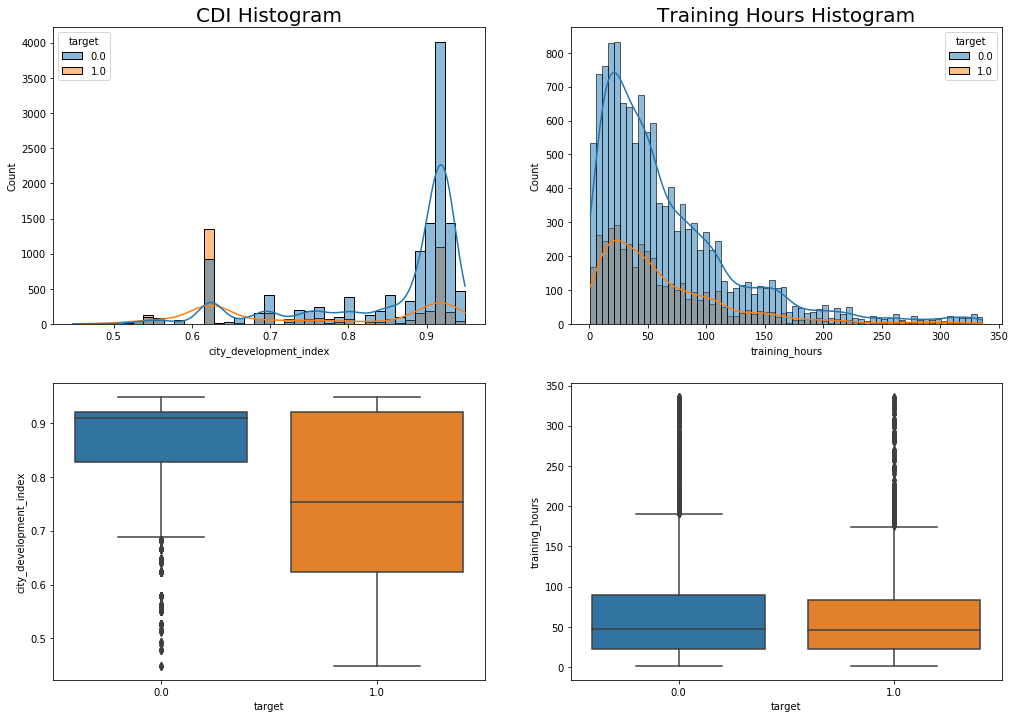

In [72]:
plt.figure(figsize=(17,12))

plt.subplot(221)
sns.histplot(data=df,x='city_development_index',hue='target',kde=True)
plt.title('CDI Histogram',fontsize=20)

plt.subplot(222)
sns.histplot(data=df,x='training_hours',hue='target',kde=True)
plt.title('Training Hours Histogram',fontsize=20)

plt.subplot(223)
sns.boxplot(data=df,y='city_development_index', x='target')

plt.subplot(224)
sns.boxplot(data=df,y='training_hours', x='target')
plt.show()

Berdasarkan histogram dan boxplot diatas, kita dapat menyimpulkan bahwa terlihat perbedaan distribusi `city_development_index` dari target yang 0 (tidak tertarik) dan target yang 1 (yang tertarik), dimana yang tertarik biasa `city_development_index`nya lebih rendah dari yang tidak tertarik.

Sedangkan kalau distribusi `training_hours` kurang lebih sama antara target 0 dan 1. Dimana berarti kemungkinan `training_hours`ini tidak mempengaruhi seorang kandidat jadi tertarik dan tidaknya.

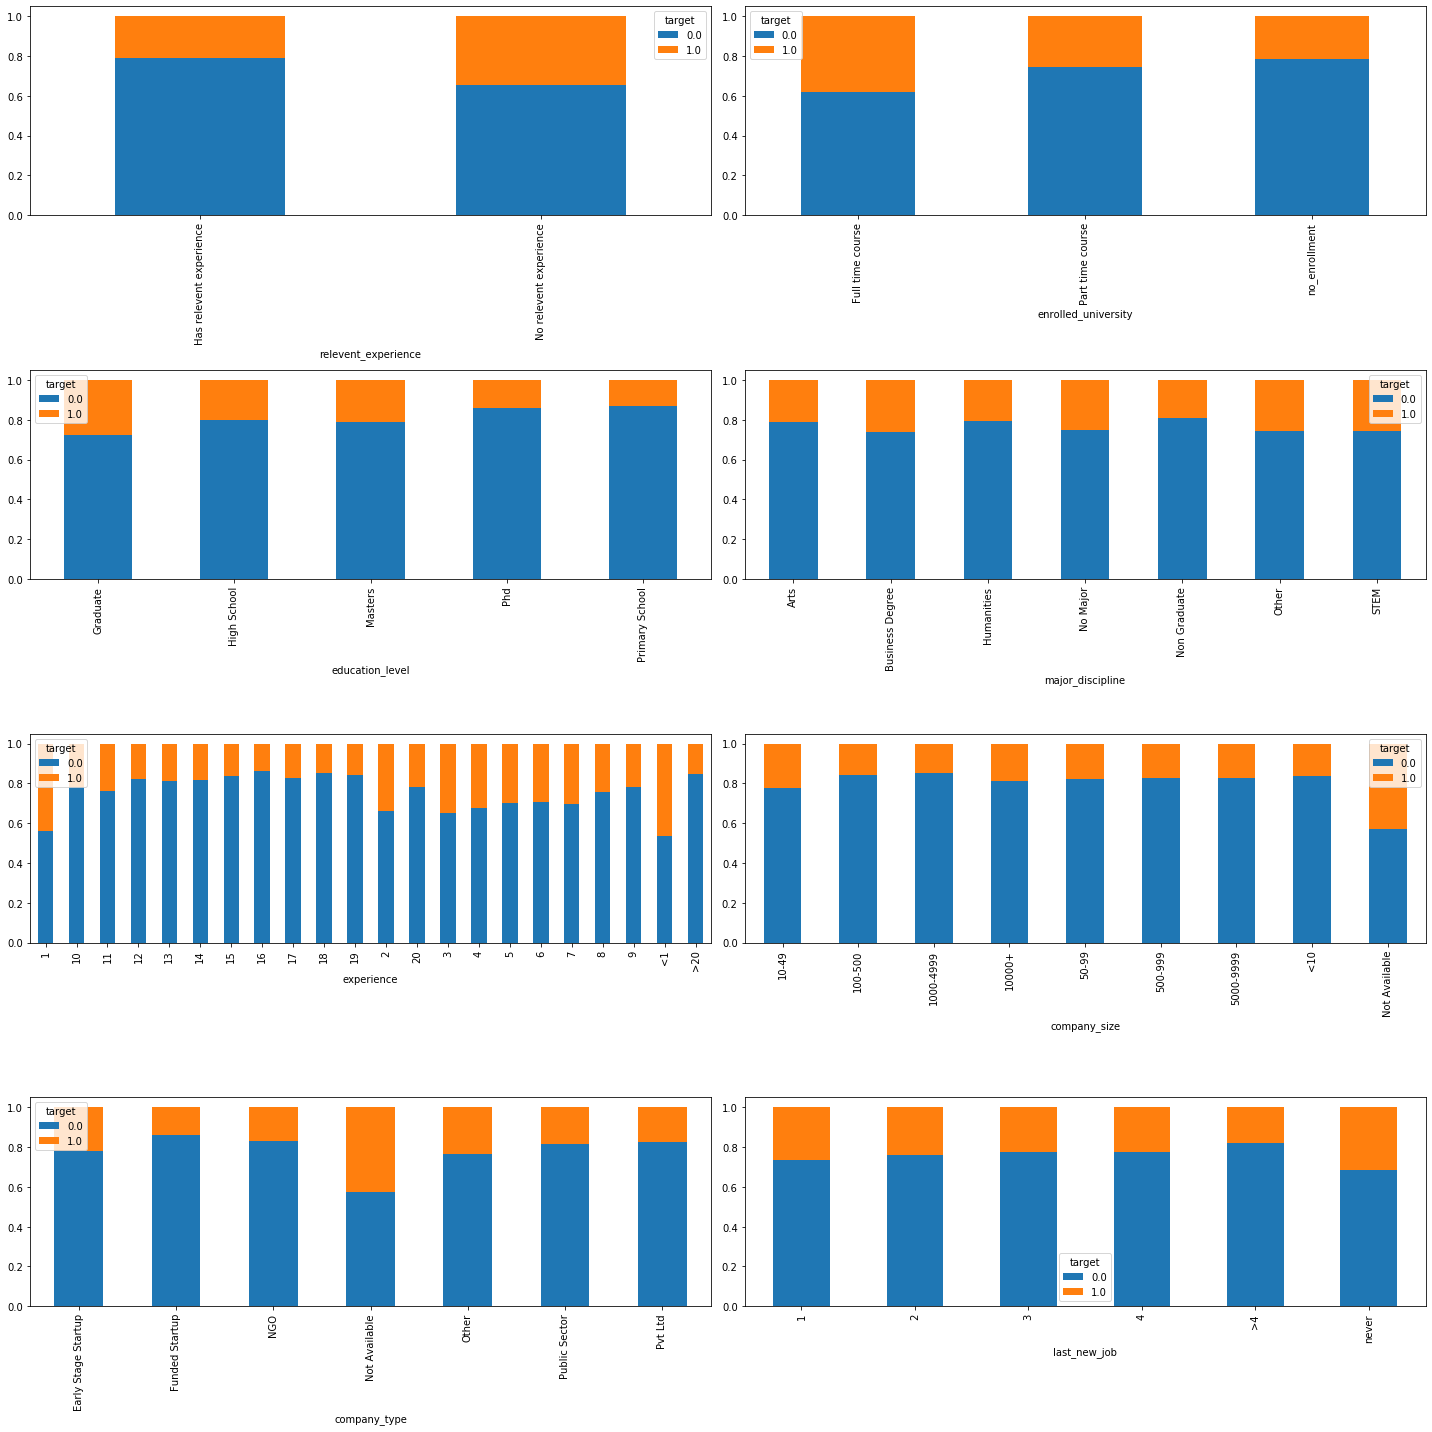

In [73]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['target','city','city_development_index','training_hours']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df[i],df['target'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

In [74]:
for i in df.drop(columns=['target','city','city_development_index','training_hours']).columns:
    relevent_experience_df = df.groupby(i)['target'].value_counts(normalize=True).unstack()
    display(relevent_experience_df.sort_values(by=[1.0], ascending=False))

target,0.0,1.0
relevent_experience,,
No relevent experience,0.652768,0.347232
Has relevent experience,0.788120,0.211880


target,0.0,1.0
enrolled_university,,
Full time course,0.618521,0.381479
Part time course,0.743180,0.256820
no_enrollment,0.787352,0.212648


target,0.0,1.0
education_level,,
Graduate,0.723723,0.276277
Masters,0.791307,0.208693
High School,0.798537,0.201463
Phd,0.861257,0.138743
Primary School,0.870229,0.129771


target,0.0,1.0
major_discipline,,
Business Degree,0.738170,0.261830
STEM,0.742473,0.257527
Other,0.744928,0.255072
No Major,0.748744,0.251256
Arts,0.786667,0.213333
Humanities,0.791599,0.208401
Non Graduate,0.807749,0.192251


target,0.0,1.0
experience,,
<1,0.537349,0.462651
1,0.558962,0.441038
3,0.649293,0.350707
2,0.661220,0.338780
4,0.674936,0.325064
7,0.698675,0.301325
5,0.701987,0.298013
6,0.705486,0.294514
8,0.758380,0.241620


target,0.0,1.0
company_size,,
Not Available,0.572051,0.427949
10-49,0.778374,0.221626
10000+,0.811311,0.188689
50-99,0.824408,0.175592
5000-9999,0.828125,0.171875
500-999,0.829330,0.170670
<10,0.837975,0.162025
100-500,0.841904,0.158096
1000-4999,0.852245,0.147755


target,0.0,1.0
company_type,,
Not Available,0.572051,0.427949
Other,0.766355,0.233645
Early Stage Startup,0.780357,0.219643
Public Sector,0.817380,0.182620
Pvt Ltd,0.825676,0.174324
NGO,0.831933,0.168067
Funded Startup,0.859053,0.140947


target,0.0,1.0
last_new_job,,
never,0.685475,0.314525
1,0.733564,0.266436
2,0.758685,0.241315
3,0.774573,0.225427
4,0.777090,0.222910
>4,0.819878,0.180122


Berdasarkan barplot dan table diatas kita dapat menyimpulkan beberapa hal :
1. Kandidat yang tidak memiliki pengalaman yang berhubungan sebelumnya (`No relevent experience`) lebih cenderung berminat dari pada kandidat yang `Has relevent experience`
2. Kandidat yang `enrolled_university`nya `Full time course` lebih cenderung berminat dibandingkan `enrolled_university` yang lain.
3. Kandidat yang `education_level`nya `Graduate` lebih cenderung berminat dibandingkan `education_level` yang lain.
4. Kandidat yang `major_discipline`nya `Business Degree` lebih cenderung berminat dibandingkan `major_discipline` yang lain, tetapi sebenarnya ini bedanya sangat tipis2 antara satu sama lain.
5. Kandidat yang `experience`/pengalamannya lebih rendah/sebentar biasanya lebih cenderung berminat dibandingkan dengan yang sudah lama pengalamannya.
6. Kandidat yang `company_size`nya `Not Available` lebih cenderung berminat dibandingkan `company_size` yang lain.
7. Kandidat yang `company_type`nya `Not Available` lebih cenderung berminat dibandingkan `company_type` yang lain.
8. Kandidat yang `last_new_job`nya `never` lebih cenderung berminat dibandingkan `last_new_job` yang lain, tetapi sebenarnya ini bedanya juga agak tipis2 satu sama lainnya.

Sekarang mari kita lihat juga untuk kolom city, apakah terlihat perbedaan kecenderungan minat antara kandidat dari kota yang berbeda.

In [75]:
relevent_experience_df = df.groupby('city')['target'].value_counts(normalize=True).unstack()
relevent_experience_df['count'] = df.groupby('city')['target'].count()
display(relevent_experience_df.sort_values(by=[1.0], ascending=False).head(15))
display(relevent_experience_df.sort_values(by=[1.0], ascending=False).tail(15))

target,0.0,1.0,count
city,,,
city_171,NaN,1.000000,1
city_155,0.230769,0.769231,13
city_139,0.250000,0.750000,4
city_42,0.333333,0.666667,9
city_101,0.363636,0.636364,66
city_43,0.363636,0.636364,11
city_21,0.406319,0.593681,2279
city_11,0.426606,0.573394,218
city_145,0.448276,0.551724,58


target,0.0,1.0,count
city,,,
city_23,0.919255,0.080745,161
city_36,0.920530,0.079470,151
city_97,0.921348,0.078652,89
city_28,0.924855,0.075145,173
city_138,0.926606,0.073394,109
city_72,0.933333,0.066667,15
city_69,0.937500,0.062500,16
city_111,1.000000,NaN,3
city_129,1.000000,NaN,2


Terlihat dari table diatas, bahwa ada perbedaan kecenderungan minat antara kandidat dari kota yang berbeda.

Mari kita lihat kecenderungan 4 kota dengan jumlah kandidat terbanyak.

In [76]:
df['city'].value_counts()

city_103    3946
city_21     2279
city_16     1392
city_114    1202
city_160     757
            ... 
city_111       3
city_166       3
city_129       2
city_8         2
city_171       1
Name: city, Length: 122, dtype: int64

In [77]:
relevent_experience_df.sort_values(by=[1.0], ascending=False).loc['city_103']

target
0.0         0.784085
1.0         0.215915
count    3946.000000
Name: city_103, dtype: float64

In [78]:
relevent_experience_df.sort_values(by=[1.0], ascending=False).loc['city_21']

target
0.0         0.406319
1.0         0.593681
count    2279.000000
Name: city_21, dtype: float64

In [79]:
relevent_experience_df.sort_values(by=[1.0], ascending=False).loc['city_16']

target
0.0         0.883621
1.0         0.116379
count    1392.000000
Name: city_16, dtype: float64

In [80]:
relevent_experience_df.sort_values(by=[1.0], ascending=False).loc['city_114']

target
0.0         0.897671
1.0         0.102329
count    1202.000000
Name: city_114, dtype: float64

Terlihat bahwa `city_103`,`city_16`, dan `city_114` memiliki kecenderungan kandidat yang mirip, dimana jauh lebih banyak yang tidak berminat dibandingkan yang berminat, sedangkan untuk `city_21` lebih banyak kandidat yang berminat dibandingkan yang tidak berminat walau tidak terlalu jauh.

Sekarang mari kita siapkan data kita untuk pembuatan model machine learning

## Data Preparation 

In [81]:
df.head()

,city,city_development_index,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_103,0.920,Has relevent experience,no_enrollment,Graduate,STEM,>20,Not Available,Not Available,1,36,1.0
1,city_40,0.776,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,city_21,0.624,No relevent experience,Full time course,Graduate,STEM,5,Not Available,Not Available,never,83,0.0
4,city_162,0.767,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,city_176,0.764,Has relevent experience,Part time course,Graduate,STEM,11,Not Available,Not Available,1,24,1.0


Sekarang mari kita melakukan fitur encoding untuk fitur2 categorical yang kita miliki.
Yang akan kita lakukan adalah :

1. Merubah fitur/kolom `experience` menjadi integer 0-21 dengan Ordinal Encoding, karena fitur ini adalah lama pengalaman dalam satuan tahun, dimana <1 akan kita rubah menjadi 0 saja, dan >20 akan kita rubah menjadi 21, sisanya hanya dirubah menjadi tipe data integer saja.
2. Merubah fitur/kolom `city` menggunakan Binary Encoding, karena fitur ini memiliki unique data yang banyak dan tidak memiliki urutan/tidak ordinal, bila kita menggunakan One Hot Encoding akan terlalu banyak fitur baru yg terbuat, dan kalau kita menggunakan Ordinal/Label Encoding hasilnya dapat kurang cocok/kurang baik. Oleh karena itu kita akan mencoba menggunakan Binary Encoding saja.
3. Merubah fitur/kolom `relevent_experience` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
4. Merubah fitur/kolom `enrolled_university` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
5. Merubah fitur/kolom `education_level` menggunakan One Hot Encoding, karena fitur ini walaupun memiliki urutan/ordinal, tetapi karena lompatan jarak antara `education_level` itu kemungkinan value/besarnya tidak sama, dan kita tidak tau berapa besar setiap jarak pastinya, maka akan lebih aman dan akurat bila kita menggunakan One Hot Encoding, dimana unique datanya juga hanya sedikit saja untuk fitur ini.
6. Merubah fitur/kolom `major_discipline` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
7. Merubah fitur/kolom `company_size` menggunakan One Hot Encoding, karena fitur ini walaupun memiliki urutan/ordinal, tetapi karena lompatan jarak antara `company_size` itu kemungkinan value/besarnya tidak sama, dan kita tidak tau berapa besar setiap jarak pastinya, maka akan lebih aman dan akurat bila kita menggunakan One Hot Encoding, dimana unique datanya juga hanya sedikit saja untuk fitur ini.
8. Merubah fitur/kolom `company_type` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
9. Merubah fitur/kolom `last_new_job` menggunakan One Hot Encoding, karena fitur ini walaupun memiliki urutan/ordinal, tetapi never itu kurang tepat bila kita rubah menjadi 0 karena artinya itu berbeda. Kemudian lompatan jarak antara `last_new_job` 4 dengan >4 itu kemungkinan value/besarnya tidak selalu sama, dan kita tidak tau berapa besar setiap jarak pastinya, maka akan lebih aman dan akurat bila kita menggunakan One Hot Encoding, dimana unique datanya juga hanya sedikit saja untuk fitur ini.

In [82]:
ordinal_mapping = [
    {'col':'experience',
    'mapping':{
        '<1'      :    0,
        '1'       :    1, 
        '2'       :    2, 
        '3'       :    3, 
        '4'       :    4, 
        '5'       :    5,
        '6'       :    6,
        '7'       :    7,
        '8'       :    8, 
        '9'       :    9, 
        '10'      :    10, 
        '11'      :    11,
        '12'      :    12,
        '13'      :    13, 
        '14'      :    14, 
        '15'      :    15, 
        '16'      :    16,
        '17'      :    17,
        '18'      :    18,
        '19'      :    19, 
        '20'      :    20, 
        '>20'     :    21
    }}
]

In [83]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['company_type','company_size', 'education_level', 'relevent_experience', 'last_new_job', 'major_discipline', 'enrolled_university']),
    ('ordinal', ce.OrdinalEncoder(mapping= ordinal_mapping), ['experience']),
    ('binary', ce.BinaryEncoder(), ['city'])
], remainder='passthrough')

In [84]:
x = df.drop(columns=['target'])
y = df['target']

In [85]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=2021)

In [86]:
testing = pd.DataFrame(transformer.fit_transform(x_train),columns=transformer.get_feature_names())
testing.head()

,onehot__x0_Funded Startup,onehot__x0_NGO,onehot__x0_Not Available,onehot__x0_Other,onehot__x0_Public Sector,onehot__x0_Pvt Ltd,onehot__x1_100-500,onehot__x1_1000-4999,onehot__x1_10000+,onehot__x1_50-99,onehot__x1_500-999,onehot__x1_5000-9999,onehot__x1_<10,onehot__x1_Not Available,onehot__x2_High School,onehot__x2_Masters,onehot__x2_Phd,onehot__x2_Primary School,onehot__x3_No relevent experience,onehot__x4_2,onehot__x4_3,onehot__x4_4,onehot__x4_>4,onehot__x4_never,onehot__x5_Business Degree,onehot__x5_Humanities,onehot__x5_No Major,onehot__x5_Non Graduate,onehot__x5_Other,onehot__x5_STEM,onehot__x6_Part time course,onehot__x6_no_enrollment,ordinal__experience,binary__city_0,binary__city_1,binary__city_2,binary__city_3,binary__city_4,binary__city_5,binary__city_6,binary__city_7,city_development_index,training_hours
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.624,23.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.920,94.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.910,68.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.897,16.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.920,20.0


## Modeling & Evaluation

In [87]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

### Model Benchmarking : K-Fold

In [88]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

[11:40:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:40:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:40:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:40:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,mean roc_auc,sdev
model,,
LightGBM,0.800616,0.003190
XGBoost,0.785732,0.002527
Logistic Regression,0.784260,0.002837
Random Forest,0.781712,0.005352
KNN,0.670150,0.003549
Decision Tree,0.623852,0.005190


Terlihat bahwa model LightGBM adalah yang terbaik untuk roc_aucnya dari setiap model yang menggunakan default hyperparameter

### Model Benchmarking : Test Data

In [89]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM']):
    estimator,y_pred,x_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

         0.0       0.79      0.94      0.86      2534
         1.0       0.59      0.24      0.34       832

    accuracy                           0.77      3366
   macro avg       0.69      0.59      0.60      3366
weighted avg       0.74      0.77      0.73      3366

KNN 
               precision    recall  f1-score   support

         0.0       0.80      0.88      0.84      2534
         1.0       0.47      0.33      0.39       832

    accuracy                           0.74      3366
   macro avg       0.63      0.60      0.61      3366
weighted avg       0.72      0.74      0.73      3366

Decision Tree 
               precision    recall  f1-score   support

         0.0       0.82      0.80      0.81      2534
         1.0       0.43      0.45      0.44       832

    accuracy                           0.71      3366
   macro avg       0.62      0.63      0.62      3366
weighted avg       0.72      0

,roc_auc score
model,
LightGBM,0.811131
XGBoost,0.800141
Logistic Regression,0.799241
Random Forest,0.799166
KNN,0.679392
Decision Tree,0.627541


Terlihat kembali lagi model LightGBM adalah yang terbaik performanya pada test data.

Mari sekarang kita coba melakukan oversampling untuk model LightGBM kita untuk melihat apakah kita dapat mendapatkan hasil yang lebih baik lagi.

Reference : https://lightgbm.readthedocs.io/en/latest/index.html

### Test Oversampling with K-Fold Cross Validation

In [90]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [91]:
from sklearn.model_selection import StratifiedKFold

K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [92]:
data = x_train
target = y_train

In [93]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
#     print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler()

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    # instantiate model
    lgbm = lgb.LGBMClassifier()
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',lgbm)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    
    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

#### Evaluation Metrics Without Oversampling

In [94]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.842948,0.799555,0.903040,0.807689,0.787002,0.732872,0.668447,0.606607,0.687500,0.592375
1,0.845506,0.812175,0.902641,0.822270,0.790974,0.745880,0.677129,0.609610,0.691442,0.622699
2,0.847900,0.789161,0.903237,0.793877,0.793481,0.712669,0.676795,0.552553,0.698484,0.576803
3,0.844103,0.811433,0.903144,0.791630,0.788811,0.741940,0.672454,0.591592,0.689254,0.625397
4,0.847500,0.783804,0.903688,0.776439,0.794129,0.703967,0.684246,0.536145,0.694444,0.565079
5,0.849975,0.777860,0.906779,0.782235,0.797148,0.700828,0.686916,0.548193,0.700477,0.549849
6,0.846839,0.785290,0.903354,0.794004,0.792387,0.702839,0.677129,0.522523,0.695235,0.572368
7,0.847087,0.803120,0.901975,0.804919,0.792078,0.728105,0.673122,0.561562,0.697578,0.611111
8,0.849645,0.779346,0.904009,0.801365,0.795011,0.694613,0.674457,0.510511,0.704569,0.559211
9,0.848820,0.800149,0.904331,0.800957,0.795072,0.726924,0.681135,0.570571,0.699349,0.601266


#### Evaluation Metrics With Oversampling

In [95]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.826957,0.793615,0.908981,0.811461,0.826957,0.744414,0.827012,0.717718,0.826921,0.565012
1,0.825093,0.807721,0.908695,0.823834,0.825092,0.764694,0.822298,0.768769,0.826921,0.584475
2,0.825532,0.780252,0.908300,0.794136,0.825528,0.731702,0.821201,0.717718,0.828376,0.541950
3,0.827943,0.799555,0.908016,0.792920,0.827941,0.751367,0.823942,0.726727,0.830589,0.574822
4,0.827450,0.776374,0.910251,0.775139,0.827450,0.720688,0.827779,0.668675,0.827235,0.537530
5,0.827724,0.764487,0.910688,0.773566,0.827723,0.713680,0.829752,0.695783,0.826400,0.516779
6,0.826537,0.783061,0.910233,0.795428,0.826535,0.733174,0.822646,0.708709,0.829099,0.547564
7,0.822208,0.799406,0.905500,0.807477,0.822204,0.754436,0.817933,0.750751,0.824986,0.572082
8,0.829552,0.786033,0.911099,0.795236,0.829550,0.738472,0.832621,0.726727,0.827541,0.551253
9,0.824893,0.783804,0.910165,0.792563,0.824888,0.735952,0.819687,0.723724,0.828312,0.547727


Terlihat bahwa hasil evaluation metricsnya untuk recall dari class positive lebih baik setelah di oversampling dari yang tidak di oversampling tetapi precisionnya tebakan class positive menjadi sedikit lebih buruk. 

Ini masuk akal karena class positive datanya kita perbanyak menjadi sama dengan jumlah data dari class negative, dimana ini biasa memang akan membuat recall dari class yg minoritas naik tetapi otomatis biasa precisionnya juga akan turun sebagai dampaknya. Tetapi untuk kasus kali ini recallnya naik lebih tinggi dari pada precisionnya yang turun. Dan dampak ini terhadap kasus permasalahan kita berarti model kita setelah di oversampling, menjadi mendapatkan potensial kandidat yang lebih banyak dari sebelumnya, tetapi sedikit berkurang dalam ketepatan/precision tebakannya untuk kandidat potensial, yang menyebabkan cost biaya recruitment yang terbuang menjadi lebih tinggi dari model yang tidak di oversampling.

Sekarang pertanyaannya, model manakah yang lebih baik dan harus kita gunakan? menentukan ini kembali lagi tergantung permasalahan yang sedang dihadapi dan berdasarkan pengertian/pengalaman terhadap domain permasalahannya. Dimana untuk permasalahan kali ini, yang perlu kita perhatikan dan ketahui adalah apakah selama ini kandidat yang potensial itu sudah berlebihan/terlalu banyak dan kita tidak butuh semuanya, atau kandidat yang potensial itu masih pas-pasan atau bahkan kurang. Bila kasus yang pertama yg terjadi (kandidat potensial yang berlebihan/terlalu banyak) maka kita dapat menggunakan model yang tanpa oversampling saja (precision lebih penting dari recall), dan bila kasus yang kedua yg terjadi (kandidat potensial yg pas-pasan atau kurang) maka kita dapat menggunakan model yang menggunakan oversampling (recall lebih penting dari precision).

Dimana intinya, pemilihan model yang digunakan harus berdasarkan permasalahan yang dihadapi dan yang dapat menyelesaikan masalahnya paling baik (berdampak paling baik terhadap bisnis/organisasi yang bersangkutan (stakeholdernya)).

Mari sekarang kita lihat juga classification reportsnya.

#### Classification Reports Without Oversampling

In [96]:
for rep in validation_errors_without_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87      1014
         1.0       0.59      0.61      0.60       333

    accuracy                           0.80      1347
   macro avg       0.73      0.73      0.73      1347
weighted avg       0.80      0.80      0.80      1347

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88      1014
         1.0       0.62      0.61      0.62       333

    accuracy                           0.81      1347
   macro avg       0.75      0.74      0.75      1347
weighted avg       0.81      0.81      0.81      1347

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.86      1014
         1.0       0.58      0.55      0.56       333

    accuracy                           0.79      1347
   macro avg       0.72      0.71      0.71      1347
weighted avg       0.79      0.79      0.79      1347

              preci

#### Classification Reports With Oversampling

In [97]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86      1014
         1.0       0.57      0.72      0.63       333

    accuracy                           0.79      1347
   macro avg       0.73      0.77      0.74      1347
weighted avg       0.82      0.79      0.80      1347

              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87      1014
         1.0       0.58      0.77      0.66       333

    accuracy                           0.81      1347
   macro avg       0.75      0.79      0.76      1347
weighted avg       0.83      0.81      0.82      1347

              precision    recall  f1-score   support

         0.0       0.90      0.80      0.85      1014
         1.0       0.54      0.72      0.62       333

    accuracy                           0.78      1347
   macro avg       0.72      0.76      0.73      1347
weighted avg       0.81      0.78      0.79      1347

              preci

Terlihat bahwa model yang setelah di oversampling memiliki recall dari kedua class yang lebih seimbang. Oleh karena itu untuk kasus kali ini, mari kita gunakan model yang menggunakan oversampling (menggunakan asumsi yang kedua (yaitu kita membutuhkan kandidat potensial yang lebih banyak)).

Sekarang mari kita coba melakukan hyperparameter tuning pada model LightGBM kita untuk mendapatkan hasil yang lebih baik lagi.

### Hyperparameter Tuning

References :

1. https://lightgbm.readthedocs.io/en/latest/Parameters.html
2. https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
3. https://stackoverflow.com/questions/58815016/cross-validating-with-imblearn-pipeline-and-gridsearchcv
4. https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py

In [98]:
lgbm = lgb.LGBMClassifier()
ros = RandomOverSampler(random_state=42)

estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',lgbm)
])

In [99]:
hyperparam_space=[{
    'model__max_bin': [255, 275, 300, 230],
    'model__num_leaves':[31, 21, 41, 51],
    'model__min_data_in_leaf': [20, 15, 30, 40],
    'model__num_iterations':[100,75, 125, 150],
    'model__learning_rate': [0.1, 0.075, 0.125, 0.05],
    'model__random_state': [42]
}]

default hyperparameter LGBM => `max_bin` = 255, `num_leaves` = 31, `min_data_in_leaf` = 20, `num_iterations` = 100, `learning_rate` = 0.1

In [100]:
grid = GridSearchCV(estimator, n_jobs=-1, param_grid=hyperparam_space, scoring='roc_auc', cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))

In [101]:
grid.fit(x_train,y_train)
print(grid.best_score_)
print(grid.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
0.8011296476447898
{'model__learning_rate': 0.1, 'model__max_bin': 255, 'model__min_data_in_leaf': 30, 'model__num_iterations': 75, 'model__num_leaves': 21, 'model__random_state': 42}


Hyperparameter terbaik LGBM dari hasil Gridsearch => `max_bin` = 255, `num_leaves` = 21, `min_data_in_leaf` = 30, `num_iterations` = 75, `learning_rate` = 0.1

Untuk hyperparameter `max_bin` dan `learning_rate` default valuenya tetap yang terbaik, utk `num_leaves` bisa dicoba diperkecil lagi dan dibandingkan dengan 21 (value terbaiknya skrg), utk `min_data_in_leaf` bisa dicoba disekitar angka 30 dan dibandingkan dengan 30 (value terbaiknya skrg), utk `num_iterations` bisa dicoba disekitar angka 75 dan dibandingkan dengan 75 (value terbaiknya skrg).

Tetapi untuk kali ini hyperparameter tuning yang akan kita lakukan hanya sampai sini saja, teman-teman nanti bisa mencoba tuning lebih lagi sendiri mengikuti petunjuk yang ada diatas ini. Dan juga sebenarnya kalau random_state dari modelnya, oversampling, dan KFoldnya berbeda akan menghasilkan hyperparameter terbaik yg berbeda juga, karena hasil dipengaruhi oleh datanya juga.

In [102]:
best_model = grid.best_estimator_
best_model.fit(x_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['company_type',
                                                   'company_size',
                                                   'education_level',
                                                   'relevent_experience',
                                                   'last_new_job',
                                                   'major_discipline',
                                                   'enrolled_university']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'experience',
                                                   

In [103]:
estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',lgbm)
])
estimator.fit(x_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['company_type',
                                                   'company_size',
                                                   'education_level',
                                                   'relevent_experience',
                                                   'last_new_job',
                                                   'major_discipline',
                                                   'enrolled_university']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'experience',
                                                   

In [104]:
y_pred_default = estimator.predict(x_test)
y_pred_proba_default = estimator.predict_proba(x_test)
y_pred_tuned = best_model.predict(x_test)
y_pred_proba_tuned = best_model.predict_proba(x_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default LGBM : ', roc_auc_default)
print('ROC AUC Score Tuned LGBM : ', roc_auc_tuned)

ROC AUC Score Default LGBM :  0.8087237132687756
ROC AUC Score Tuned LGBM :  0.812714629120879


Terlihat bahwa model LGBM setelah kita tuning hyperparameternya memiliki nilai ROC AUC yang lebih baik walaupun hanya naik sedikit saja.

Mari kita lihat juga perbandingan classification reportnya

In [105]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default LGBM : \n', report_default)
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Default LGBM : 
               precision    recall  f1-score   support

         0.0       0.91      0.81      0.86      2534
         1.0       0.56      0.75      0.65       832

    accuracy                           0.80      3366
   macro avg       0.74      0.78      0.75      3366
weighted avg       0.82      0.80      0.80      3366

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

         0.0       0.91      0.81      0.86      2534
         1.0       0.57      0.76      0.65       832

    accuracy                           0.80      3366
   macro avg       0.74      0.79      0.75      3366
weighted avg       0.83      0.80      0.81      3366



Kembali lagi terlihat bahwa model LGBM setelah kita tuning hyperparameternya memiliki classification report yang lebih baik walaupun hanya lebih baik sedikit saja. Oleh karena itu kita akan menggunakan model LGBM yang sudah di tuned sebagai model akhir kita.

### Feature Importances

Mari sekarang kita lihat fitur/kolom apa saja yang paling penting untuk model LGBM kita

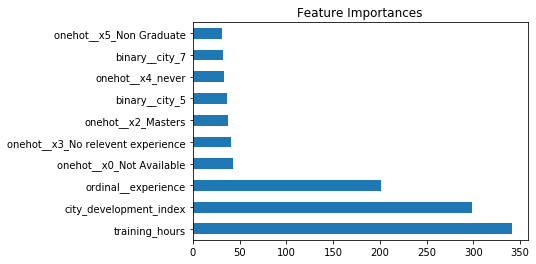

In [106]:
coef1 = pd.Series(best_model['model'].feature_importances_, transformer.get_feature_names()).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

Terlihat bahwa ternyata untuk model LGBM kita, fitur/kolom training_hours adalah yang paling penting, kemudian diikuti dengan city_development_index, ordinal_experience, dan selanjutnya.

Nanti kedepannya sebenarnya kolom training_hours harus dihapus bila model yg kita buat ini ingin digunakan untuk memprediksi kandidat kita sebelum mereka memulai training/diterima untuk ikut training. Tetapi untuk kali ini asumsi yang kita akan gunakan adalah training yang diadakan tersebut tidak gratis/berbayar, jadi kita akan menggunakan modelnya setelah trainingnya selesai, untuk memfilter siapa yang perlu kita tawarkan untuk bekerja. Dimana berarti model yang kita buat ini akan membantu mengurangi cost dari segi hiringnya, dimana yang perlu di tawarkan jadi lebih terarah dan efisien.

## Conclusion & Recommendation

In [107]:
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

         0.0       0.91      0.81      0.86      2534
         1.0       0.57      0.76      0.65       832

    accuracy                           0.80      3366
   macro avg       0.74      0.79      0.75      3366
weighted avg       0.83      0.80      0.81      3366



Berdasarkan hasil classification report dari model kita, kita dapat menyimpulkan/mengambil konklusi bahwa bila seandainya nanti kita menggunakan model kita untuk memfilter/menyaring list kandidat yang akan kita coba tawarkan, maka model kita dapat mengurangi 81% kandidat yang tidak tertarik untuk tidak kita approach, dan model kita dapat mendapatkan 76% kandidat yang tertarik dari seluruh kandidat yang tertarik. (semua ini berdasarkan recallnya)

Model kita ini memiliki ketepatan prediksi kandidat yang tertarik sebesar 57% (precisionnya), jadi setiap model kita memprediksi bahwa seorang kandidat itu tertarik, maka kemungkinan tebakannya benar itu sebesar 57% kurang lebih. Maka masih akan ada kandidat yang sebenarnya tidak tertarik tetapi diprediksi sebagai kandidat yang tertarik sekitar 19% dari keseluruhan kandidat yang tidak tertarik (berdasarkan recall).

Bila seandainya biaya untuk screening/menyaring data per kandidat itu 40$ (berdasarkan sumber dari https://appliqant.com/2018/07/30/the-cost-of-an-interview/, dan andaikan jumlah kandidat yang kita miliki untuk suatu kurun waktu sebanyak 200 orang (dimana andaikan 100 orang tertarik, dan 100 orang lagi tidak tertarik), maka hitungannya kurang lebih akan seperti ini :

Tanpa Model (semua kandidat kita check dan tawarkan) :
- Total Biaya => 200 x 40 USD = 8000 USD
- Total Kandidat Tertarik yang didapatkan => 100 orang (karena semua kita tawarkan)
- Total Kandidat Tertarik yang tidak didapatkan => 0 orang (karena semua kita tawarkan)
- Biaya yang terbuang => 100 x 40 USD = 4000 USD (karena 100 orang menolak dan menjadi sia-sia)
- Jumlah penghematan => 0 USD

Dengan Model (hanya kandidat yang diprediksi oleh model tertarik yang kita check dan tawarkan) :
- Total Biaya => (76 x 40 USD) + (19 x 40 USD) = 3040 USD + 760 USD = 3800 USD
- Total Kandidat Tertarik yang didapatkan => 76 orang (karena recall 1/yg tertarik itu 76%)
- Total Kandidat Tertarik yang tidak didapatkan => 24 orang (karena recall 1/yg tertarik itu 76%)
- Biaya yang terbuang => 19 x 40 USD = 760 USD (berdasarkan recall 0/yg tidak tertarik (19 orang menolak tawaran/tidak tertarik))
- Jumlah penghematan => 81 x 40 USD = 3240 USD (yang dihitung hanya yang memang tidak tertarik saja, kalau yang tertarik tapi tidak ditawarkan itu tidak dihitung disini)

Berdasarkan contoh hitungan tersebut, terlihat bahwa dengan menggunakan model kita, maka perusahaan tersebut akan menghemat biaya yang cukup besar tanpa mengorbankan terlalu banyak jumlah kandidat potensial/kandidat yg tertarik.

#### Recommendation

Hal-hal yang bisa dilakukan untuk mengembangkan project dan modelnya lebih baik lagi :
- Membuat kebijakan baru yang mendorong setiap kandidat untuk mengisi semua data yang diperlukan kedepannya, dan juga bila sedang tidak bekerja di suatu perusahaan, `company_type` dan `company_size`nya bisa diisi dengan informasi bahwa memang tidak ada dari pada kosong saja. 
- Menambahkan fitur2 atau kolom2 baru yang kemungkinan bisa berhubungan dengan ketertarikannya, seperti alamat kandidatnya (untuk menghitung jarak dari tempat tinggalnya ke kantor perusahaan tersebut), gaji atau pendapatannya sekarang, jabatan pekerjaannya sekarang (apakah karyawan, manager, direktur, dan sebagainya), tunjangan apa saja yang didapatkan ditempat kerjanya sekarang, dll.
- Mencoba algorithm ML yang lain dan juga mencoba hyperparameter tuning kembali, coba gunakan teknik oversampling yang berbeda juga selain Random Over Sampling, seperti SMOTENC, dll. 
- Menganalisa data-data yang model kita masih salah tebak untuk mengetahui alasannya dan karakteristiknya bagaimana.

# Goodluck & Thank You